<h2 align="center"> Gaussian Mixture Model from Scratch (Code) </h2> 
<h3 align="center"> Author: Ibrahim O Alabi, PhDc </h3>

This notebook is part of my series on Introduction to Python for Data Science. This is my way of contributing to open source knowledge. If you find this content useful, please consider leaving a **star** on this [repository](https://github.com/Ibrahim-Ola/homemade-ML.git).

## Implementation from Scratch

To implement, I have written a Class called `GaussianMixModel`. The Class allows users to input intial parameters $\Theta = \{\pi_k, \boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k, k = 1,2, \cdots, K\}$ of their choice. If it is left empty, the algorithm splits the supplied data into $k$ equal sub-parts, where $k$ is the number of clusters to be formed. The means and covariances of these $k$ dinstinct sub-parts are used for parameter initialization. The mixure weight is initialized as $\frac{1}{k}$. Finally, $\mathcal{N}(\textbf{x}| \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)$ is compted using the $\texttt{multivariate_normal.pdf}$ function from $\texttt{Scipy}$. See [Scipy documentation](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.multivariate_normal.html).

In [2]:
class GaussianMixModel(object):
    
    def __init__(self):
        self.init_means = None
        self.init_cov = None
        self.init_weights = None
    
    def _log_likelihood(self,X, mean_vec, cov_vec, pi_vec):
        
        """
        A function that computes the likelihood as defined by the Gaussian Mixture Model
        """

        n = X.shape[0] # n = sample size
        n_cluster = len(mean_vec)

        log_lik_val = 0

        for i in range(n):
            val = np.zeros(n_cluster)
            for k in range(n_cluster):
                val[k] = pi_vec[k]*np.log(multivariate_normal.pdf(X[i], mean = mean_vec[k], cov = cov_vec[k]))
            log_lik_val+= logsumexp(val)
        return log_lik_val


    
    def EM(self, X, n_clust, init_means = None, init_cov = None, init_weights = None, 
                         max_iters = 1000, tol = 1e-3):
        
        """
        Expectation Maximization Algorithm
        
        Arguments:
        ----------
        * X: the data matrix
        * n_clust (int): number of components/clusters
        * init_means, init_cove, init_weights (array): the inital parameters
        * max_iters: maximum number of iterations
        * tol: acceptable error

        Returns:
        --------
        * prints the number of iterations to convergence
        """
        
        ## Initialize parameters
    
        if (self.init_means and self.init_cov and self.init_weights) == None:
            init_split = np.array_split(X, n_clust)
            self.init_weights = np.ones(n_clust)/n_clust
            self.init_means = []
            self.init_cov = []
        
            for cluster in range (n_clust):
                self.init_means.append(np.mean(init_split[cluster], axis = 0))
                self.init_cov.append((np.cov(init_split[cluster].T, bias=False)))
        
        self.init_means = np.array(self.init_means)
        self.init_cov = np.array(self.init_cov)   
    
    
        n, p = X.shape[0], X.shape[1] # n = sample size and p = number of variables (independent)
    
        init_log_lik = self._log_likelihood(X, self.init_means, self.init_cov, self.init_weights)
    
        self.r_score = np.zeros((n, n_clust))  ## initialize responsibility matrix
        
        self.optimal_weights = self.init_weights
        self.optimal_means = self.init_means
        self.optimal_cov = self.init_cov
    
        for j in range(max_iters):
        
        #############################################################
        #                                                           #
        #              Expectation Step: soft assignment            #
        ##         Computing the responsibility score (r_score)    ##
        #                                                           #
        #############################################################
        
            for i in range(n):
                for k in range(n_clust):
                    self.r_score[i, k] = self.optimal_weights[k] * \
                    multivariate_normal.pdf(X[i], self.optimal_means[k], self.optimal_cov[k])
            denominator = self.r_score.sum(axis=1) ## denominator of the bayes rule
            denominator = denominator.reshape(-1,1) ## reshape the sum in a column vector for easy division
            self.r_score /= denominator
        
        
        #############################################################
        #                                                           #
        #                       Maximization Step:                  #
        ##         We would update the mean, covariance, and pi    ##
        #                                                           #
        #############################################################
        
            col_sum = np.sum(self.r_score, axis= 0)
        
            for k in range(n_clust):
            
                self.optimal_weights[k] = col_sum[k]/n  ## pi Update
            
                weighted_sum = 0
            
                for i in range(n):
                    weighted_sum += (self.r_score[i,k]*X[i])
                self.optimal_means[k] = weighted_sum/col_sum[k]  ## Means Update
      
                weighted_sum = np.zeros((p, p))
                for i in range(n):
                    weighted_sum += (self.r_score[i,k]*np.outer(X[i]-self.optimal_means[k],
                                                            X[i]-self.optimal_means[k]))
                self.optimal_cov[k] = weighted_sum/col_sum[k]  ## Covariance Update
            
        
        ########################################
        #                                      #
        #           Test Convergence           #
        ##        Using log-likelihood        ##
        #                                      #
        ########################################

            present_log_lik = self._log_likelihood(X, self.optimal_means, 
                                                  self.optimal_cov, self.optimal_weights) 

            if np.abs(init_log_lik - present_log_lik) < tol:
                print("GMM Converged at Iteration", j+1)
                break
            else:
                init_log_lik = present_log_lik
        return self
            
    
    def predicted_probabilities(self):
        
        """A function that returns the responcibility scores for all observations"""
        
        return self.r_score
    
    def cluster_assignment(self):
        
        """A funtion that returns Cluster Assignments for all Observations"""
        
        clusters = np.argmax(self.r_score, axis= 1)
        return clusters      


## Implemetation on a random dataset

In [8]:
import numpy as np
from sklearn import datasets
from scipy.special import logsumexp
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture

GMM Converged at Iteration 25


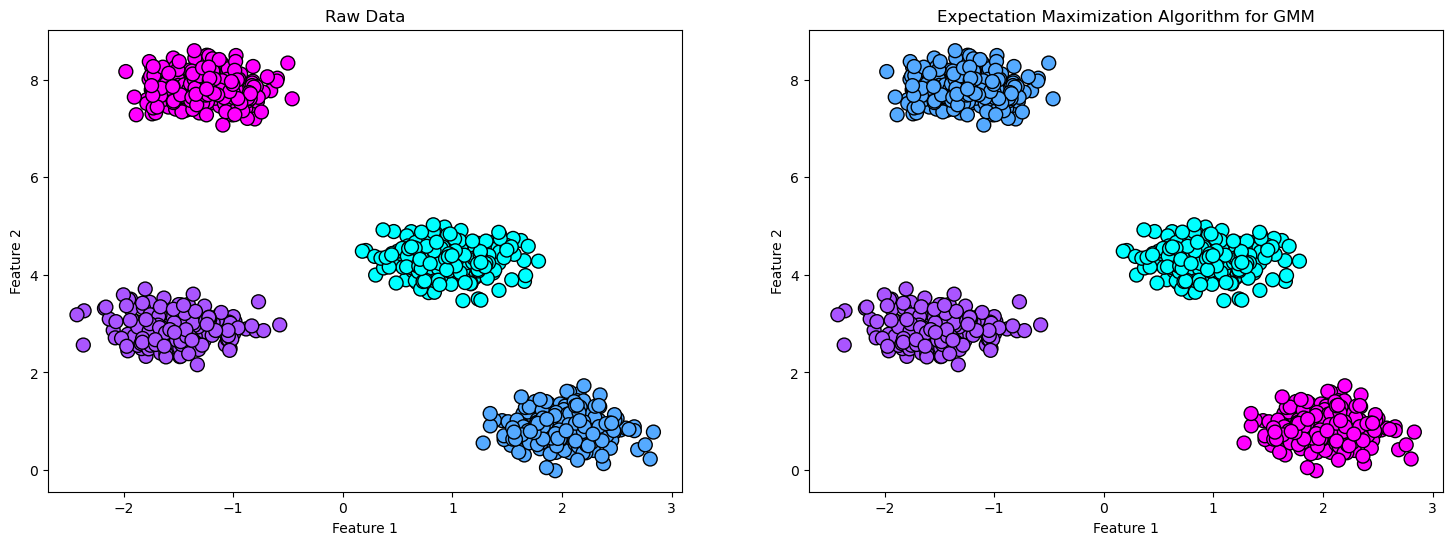

In [9]:
X, y = datasets.make_blobs(n_samples=1000, n_features=2,
               centers=4, cluster_std=.3, random_state=0) ## random_state for reproducibility


model = GaussianMixModel()
model.EM(X, n_clust=4)
pred_val = model.cluster_assignment()


fa = plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.scatter(X[:, 0],X[:, 1],c=y, cmap=plt.cm.cool, s = 100,  marker='o', edgecolor='black')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Raw Data")


plt.subplot(1,2,2)
plt.scatter(X[:, 0],X[:, 1],c=pred_val, cmap=plt.cm.cool, s = 100,  marker='o', edgecolor='black')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Expectation Maximization Algorithm for GMM")
plt.show()